In [276]:
# Import packages
import torch
import torchvision
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset 
from torch.utils.data.dataloader import default_collate
from torch.utils.data import Dataset
import torch.optim as optim
import time
import glob 
import numpy as np
import collada
from __future__ import print_function, division
import torch.nn as nn
from torch.autograd import Variable
import copy
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [277]:
# CONFIG #
# Adapted from Assignment 2 codebase

# TRAINING SETTINGS
NUM_EPOCHS = 7


# LEARNING RATE SETTINGS
BASE_LR = 0.01 # originally 0.001
DECAY_WEIGHT = 0.0001  # factor by which the learning rate is reduced; originally 0.1
EPOCH_DECAY = 30 # number of epochs after which the learning rate is decayed exponentially by DECAY_WEIGHT.


# DATASET INFO
NUM_CLASSES = 7 # set the number of classes in your dataset
# DATA_DIR = '' # to run with the sample dataset, just set to 'hymenoptera_data'


# DATALOADER PROPERTIES
BATCH_SIZE = 128 # originally 10


# GPU SETTINGS
#TORCH_DEVICE = 'mps:0' # Enter device ID of your gpu if you want to run on gpu. Otherwise neglect.
device = torch.device("mps")
GPU_MODE = 1 # set to 1 if want to run on gpu.


# SETTINGS FOR DISPLAYING ON TENSORBOARD
USE_TENSORBOARD = 0 #if you want to use tensorboard set this to 1.
TENSORBOARD_SERVER = "YOUR TENSORBOARD SERVER ADDRESS HERE" # If you set.
EXP_NAME = "fine_tuning_experiment" # if using tensorboard, enter name of experiment you want it to be displayed as.


In [278]:
# Create a function to convert the directional metadata to unique IDs so it is easier to process later on
# Source: ChatGPT; generated with prompt: 'can you help me make a code that converts that vector into the following ids'

def vector_to_direction_id(vector):
    # If it's NaN, assign it class 6
    if pd.isna(vector):
        return 6

    # Clean the string (remove brackets, quotes, spaces)
    vector = str(vector).strip("[]'").replace(" ", "")

    direction_map = {
        '1\\,0\\,0': 0,   # x-up
        '-1\\,0\\,0': 1,  # x-down
        '0\\,1\\,0': 2,   # y-up
        '0\\,-1\\,0': 3,  # y-down
        '0\\,0\\,1': 4,   # z-up
        '0\\,0\\,-1': 5   # z-down
    }

    # Return the mapped direction or fallback to 6 (treat unknowns as NaN too)
    return direction_map.get(vector, 6)


# Example usage:
# vector = "['0\\,0\\,1']"
# direction_id = vector_to_direction_id(vector)
# print(f"The direction ID for {vector} is: {direction_id}")


In [279]:
# Import metadata to obtain object labels

metadata = pd.read_csv('/Users/ellacho/Documents/NB240/ShapeNetSem-backup/metadata.csv')

# Filter to select fullID and up

metadata_filtered = metadata[['fullId', 'up']].copy()

# Remove wss. prefix from full IDs 
# Source: https://www.reddit.com/r/learnpython/comments/ozacc3/how_do_i_remove_remove_stuff_like_from_a_string/
metadata_filtered['fullId'] = metadata_filtered['fullId'].str.replace('wss.', '')

# Change up to have unique IDs 
up_ID = np.zeros(len(metadata_filtered['up']))
for i in range(len(metadata_filtered['up'])):
    up_ID[i] = vector_to_direction_id(metadata_filtered['up'][i])

metadata_filtered['up'] = up_ID
# Create a dictionary
metadata_filtered_dict = metadata_filtered.set_index('fullId').T.to_dict('list')

In [280]:
# Get list of filenames in binvox png folder
# Source: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

from os import listdir
from os.path import isfile, join

mypath = '/Users/ellacho/Documents/NB240/ShapeNetSem-backup/models_binvox_png'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

# Remove suffix to get base name
onlyfiles_base = [file.removesuffix('.png') for file in onlyfiles]

In [281]:
# Define transformations for training and validation
# Adapted from Assignment 2 codebase

# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(224),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(72),  # Slightly larger for random cropping
        transforms.RandomCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}



In [282]:
from shapenetsem_data import ShapeNetSem

In [283]:
data_dir = '/Users/ellacho/Documents/NB240/ShapeNetSem-backup/models_binvox_png'

In [284]:
full_dataset = ShapeNetSem(data_dir, onlyfiles_base, metadata_filtered_dict)

In [285]:
# import os
# import glob
# from torch.utils.data import Dataset
# from PIL import Image
# import torchvision.transforms as transforms

# #DATA_DIR = '/Users/ellacho/Desktop/test'
# DATA_DIR = '/Users/ellacho/Documents/NB240/ShapeNetSem-backup/models_binvox_png'

# class ShapeNetSem(Dataset):
#     def __init__(self, transform=None, target_transform=None):
#         self.data_dir = DATA_DIR
#         self.transform = transform or transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.ToTensor()
#         ])
#         self.target_transform = target_transform
#         self.items = []

#         for basefilename in onlyfiles_base:
#             file_paths = glob.glob(f"{self.data_dir}/**/{basefilename}.png", recursive=True)
#             for file_path in file_paths:
#                 if basefilename not in metadata_filtered_dict:
#                     continue
#                 label = metadata_filtered_dict[basefilename]
#                 self.items.append((file_path, label))

#     def __len__(self):
#         return len(self.items)

#     def __getitem__(self, idx):
#         img_path, label = self.items[idx]
        
#         # Load the image
#         image = Image.open(img_path).convert("RGB")

#         # Apply transformations if any
#         if self.transform:
#             image = self.transform(image)
#         else:
#             image = transforms.ToTensor()(image)  # Converts PIL image to a tensor

#         # Convert label to a tensor
        
#         label = torch.tensor(label, dtype=torch.long).squeeze()  # Ensure labels are long integers (used for classification)

#         return image, label

In [286]:
use_gpu = GPU_MODE

In [287]:
# Generate train and val datasets
from torch.utils.data import random_split

# Define split sizes (80/20)
train_size = int(0.8*len(full_dataset))
val_size = len(full_dataset) - train_size

train_data, val_data = random_split(full_dataset, [train_size, val_size])

In [290]:
# Define dataset as dict
dsets = {}

dsets['train'] = train_data
dsets['val'] = val_data

In [291]:
# Define dataset loaders 

# Get dataset sizes
dset_sizes = {'train': len(dsets['train']), 'val': len(dsets['val'])}

# Define DataLoaders
dset_loaders = {
    'train': DataLoader(dsets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=1),
    'val': DataLoader(dsets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=1)
}

In [292]:
# Define dset_sizes

dset_sizes = {split: len(dsets[split]) for split in ['train', 'val']}
print(dset_sizes)

{'train': 9829, 'val': 2458}


In [293]:
import time
import torch
import copy

def train_model(model, criterion, optimizer, lr_scheduler, num_epochs):
    since = time.time()

    best_model = model.to(device)
    best_acc = 0.0

    accuracies = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}
    
    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to eval mode for validation (no need to track gradients)

            running_loss = 0.0
            running_corrects = 0

            counter = 0
            # Iterate over data, getting one batch of inputs (images) and labels each time.
            for inputs, labels in dset_loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

                # Set gradient to zero to delete history of computations in previous epoch. Track operations so that differentiation can be done automatically.
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                # Print a line every 10 batches so you have something to watch and don't feel like the program isn't running.
                if counter % 10 == 0:
                    print("Reached batch iteration", counter)

                counter += 1

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Update running loss and correct predictions
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            # Calculate loss and accuracy for this epoch
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.item() / float(dset_sizes[phase])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            accuracies[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)

            # Deep copy the model if it improves accuracy
            if phase == 'val':
                if USE_TENSORBOARD:
                    foo.add_scalar_value('epoch_loss', epoch_loss, step=epoch)
                    foo.add_scalar_value('epoch_acc', epoch_acc, step=epoch)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model)
                    print('new best accuracy =', best_acc)

        # End of epoch — free MPS memory if needed
        if device.type == 'mps':
            torch.mps.empty_cache()

    # Training time
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return best_model, accuracies, losses


In [294]:
# Define function for modifying learning rate

def exp_lr_scheduler(optimizer, epoch, init_lr=BASE_LR, lr_decay_epoch=EPOCH_DECAY):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (DECAY_WEIGHT**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [296]:
# Define model architecture
model_ft = models.resnet18(pretrained=True)
# model_ft = Model(3, 10)

# Modify the first convolutional layer
model_ft.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
# model_ft.maxpool = nn.Identity()  # Remove the max pooling layer to preserve resolution
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 7)

criterion = nn.CrossEntropyLoss()

if use_gpu:
    criterion.to(device)
    model_ft.to(device)

#optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.01) # originally lr=0.0001
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)

In [297]:
# Run the functions and save the best model in the function model_ft.
model_ft_6, accuracies_6, losses_6 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

for split in ['train', 'val']:
    print(split, "accuracies by epoch:", accuracies_6[split])
    print(split, "losses by epoch:", losses_6[split])

----------
Epoch 0/6
----------
LR is set to 0.01
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
Reached batch iteration 50
Reached batch iteration 60
Reached batch iteration 70
train Loss: 0.0068 Acc: 0.6854
Reached batch iteration 0
Reached batch iteration 10
val Loss: 0.0066 Acc: 0.6876
new best accuracy = 0.6875508543531327
----------
Epoch 1/6
----------
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20


KeyboardInterrupt: 

In [ ]:
# Define path to save models 

path_to_set = "/Users/ellacho/Documents/NB240" # paste path here
os.chdir(path_to_set)
print("Current Working Directory:", os.getcwd())

In [299]:
# Batch Size = 15, Epochs = 7

# torch.save(model_ft.state_dict(), 'shapenetsem_1.pt')

# Batch Size = 20, Epochs = 10
# torch.save(model_ft.state_dict(), 'shapenetsem_2.pt')

# Batch Size = 50, Epochs = 10 # ResNet50 instead of 18 to match the other models
# torch.save(model_ft.state_dict(), 'shapenetsem_4.pt')

# # Batch Size = 64, Epochs = 7 # ResNet18 
# torch.save(model_ft_5.state_dict(), 'shapenetsem_5.pt')


# # Batch Size = 64, Epochs = 7 # ResNet18 
torch.save(model_ft_5.state_dict(), 'shapenetsem_5.pt')

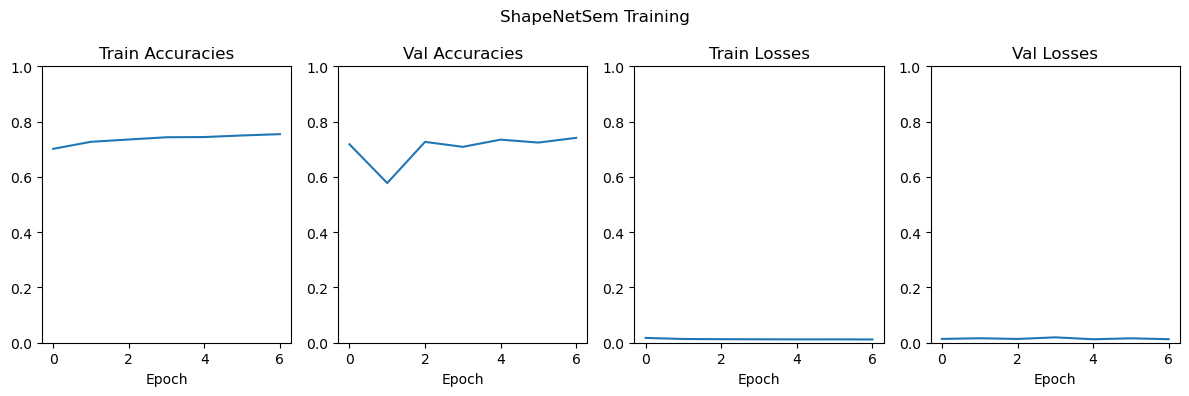

In [ ]:
# Create subplots
fig, ax = plt.subplots(1, 4, figsize = (12,4))
fig.suptitle("ShapeNetSem Training", fontsize=12) 

ax[0].plot(accuracies_6['train'])
ax[0].set_title('Train Accuracies')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim(0, 1)

ax[1].plot(accuracies_6['val'])
ax[1].set_title('Val Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(0, 1)

ax[2].plot(losses_6['train'])
ax[2].set_title('Train Losses')
ax[2].set_xlabel('Epoch')
ax[2].set_ylim(0, 1)

ax[3].plot(losses_6['val'])
ax[3].set_title('Val Losses')
ax[3].set_xlabel('Epoch')
ax[3].set_ylim(0, 1)

plt.tight_layout()

# plt.savefig("ShapeNetSemTraining_6.png", dpi=300)

# plt.show()

In [ ]:
# from PIL import Image
# img = Image.open('/Users/ellacho/Documents/NB240/ShapeNetSem-backup/models_binvox_png/1a2a5a06ce083786581bb5a25b17bed6.png')
# print(img.size)  # (width, height)
# print(img.mode)  # e.g., 'RGB' or 'L' for grayscale

(224, 224)
L
